In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
#helper functions from Coursera
def cats_vs_dogs_annotations(file_path):
    annotations = {}
    
    with open(file_path, 'r') as f:
        rows = f.read().splitlines()

    for i, row in enumerate(rows):
        image_name, _, _, _ = row.split(' ')
        image_name += '.jpg'
        if image_name[0].lower() != image_name[0]:
            class_name = 'cat'
        else:
            class_name = 'dog'
        annotations[image_name] = class_name
    
    return annotations, i + 1

In [50]:
def display_examples(x, y, p, images, index_to_class):

    print('Displaying first 8 examples..')

    if len(images) < 8:
        print('Need at least 8 examples')
        return None

    plt.figure(figsize=(12, 8))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
        gt = int(np.squeeze(y[i]) > 0.5)
        pred = int(np.squeeze(p[i]) > 0.5)
        col = 'green' if gt == pred else 'red'
        plt.xlabel(index_to_class[pred], color=col)
    return plt

In [7]:
class_to_index = {'cat': 0, 'dog': 1}
index_to_class = {0: 'cat', 1: 'dog'}

train_annot, count_train = cats_vs_dogs_annotations('data/annotations/trainval.txt')
test_annot, count_test = cats_vs_dogs_annotations('data/annotations/test.txt')

print('Training examples count ', count_train)
print('Test examples count ', count_test)

Training examples count  3680
Test examples count  3669


In [10]:
a=np.array([1,2,3,4])
b=np.array([2,4,6,8])
for i,j in enumerate(b):
    print(i,j)

0 2
1 4
2 6
3 8


In [27]:
a=np.random.randint(0,20,size=20)
print(a)
np.random.choice(a=a,size=4,replace=False)

[ 6  9  5 15 11 18  3 13  7  2  9  8 14 17 11 16  4  8  4  1]


array([ 5,  1,  8, 11])

In [23]:
np.random.randint(low=0,high=20-1,size=4)
#in randint there can be repititions in chice we can set repetitions to false.

array([ 7,  2, 13, 10])

In [29]:
img_dir="data/images/"

In [32]:
#creating a random batch of images
def random_batch(annot,batch_size=4):
    #annot argument has to annotations to the dataset(train and test sets).A dictionary
    #batch_size :default value is 4
    
    #gets all the keys in the dataset
    all_keys = list(annot.keys())
    #length of the dataset
    total_examples = len(all_keys)
    
    # a random choice of indices 
    indices=np.random.choice(a=range(total_examples),size=batch_size,replace=False)
    
    #placeholder
    X = np.zeros(shape=(batch_size,128,128,3)) # each image is of 128*128 size with 3 filters. There are batch_size number of examples in the set
    Y = np.zeros(shape=(batch_size,1)) #target array
    
    # a list that holds all the images
    images=[]
    
    for i,index in enumerate(indices):
        img_path = os.path.join(img_dir, all_keys[index])
        img = tf.keras.preprocessing.image.load_img(path = img_path, target_size = (128,128))
        
        arr = tf.keras.preprocessing.image.img_to_array(img)
        arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
        arr = np.expand_dims(arr,axis=0)
        X[i] = arr
        Y[i] = class_to_index[annot[all_keys[index]]]
        images.append(img)
    
    return X,Y,images

In [33]:
X,Y,images=random_batch(annot=train_annot,batch_size=8)

Displaying first 8 examples..


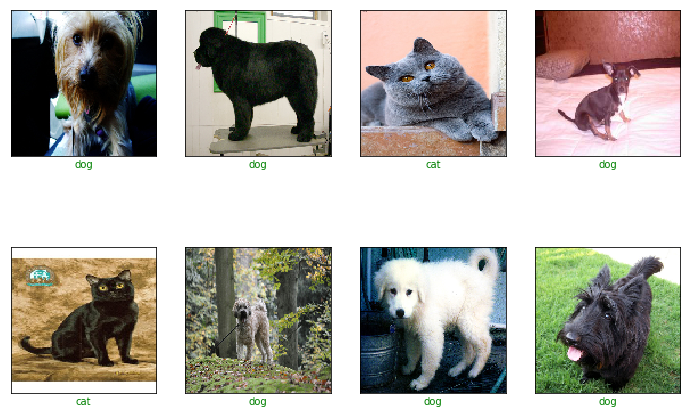

In [34]:
display_examples(X,Y,Y,images,index_to_class).show()

In [35]:
mobnet=tf.keras.applications.mobilenet_v2.MobileNetV2(include_top = False,
                                                     pooling = 'avg',
                                                     weights = 'imagenet',
                                                     input_shape = (128,128,3))
mobnet.summary()

9412608/9406464 [==============================] - 29s 3us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________

In [ ]:
#try the model as such and with modification
#also try with VGG16 and VGG19

In [ ]:
# here pre-trained weights are not trained 
# try it with training those weights as well

In [36]:
model=tf.keras.models.Sequential(layers=[mobnet,
                                         tf.keras.layers.Dropout(0.5),
                                         tf.keras.layers.Dense(1,activation='sigmoid')])
model.layers[0].trainable=False

In [37]:
model.layers[0].trainable=False

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [38]:
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [39]:
def data_generator(batch_size, annot):
    while True:
        x, y, _ = random_batch(annot,batch_size)
        yield (x,y)

In [40]:
batch_size=32
steps_per_epoch = int(count_train/batch_size)
validation_steps = int(count_test/batch_size)

print(steps_per_epoch,validation_steps)

115 114


In [45]:
model.fit_generator(generator=data_generator(batch_size,train_annot),
                   validation_data=data_generator(batch_size,test_annot),
                   steps_per_epoch=steps_per_epoch,
                   validation_steps=validation_steps,
                   epochs=10)

Epoch 1/10
115/115 [==============================] - 551s 5s/step - loss: 0.2687 - accuracy: 0.8894 - val_loss: 0.1177 - val_accuracy: 0.9608
Epoch 2/10
115/115 [==============================] - 595s 5s/step - loss: 0.2236 - accuracy: 0.9084 - val_loss: 0.1267 - val_accuracy: 0.9619
Epoch 3/10
115/115 [==============================] - 316s 3s/step - loss: 0.1935 - accuracy: 0.9209 - val_loss: 0.0904 - val_accuracy: 0.9679
Epoch 4/10
115/115 [==============================] - 314s 3s/step - loss: 0.1760 - accuracy: 0.9315 - val_loss: 0.0782 - val_accuracy: 0.9718
Epoch 5/10
115/115 [==============================] - 315s 3s/step - loss: 0.1607 - accuracy: 0.9367 - val_loss: 0.0763 - val_accuracy: 0.9762
Epoch 6/10
115/115 [==============================] - 315s 3s/step - loss: 0.1658 - accuracy: 0.9375 - val_loss: 0.0722 - val_accuracy: 0.9756
Epoch 7/10
115/115 [==============================] - 315s 3s/step - loss: 0.1685 - accuracy: 0.9337 - val_loss: 0.0794 - val_accuracy: 0.9731

In [52]:
x_test,y_test,images_test = random_batch(annot=test_annot,batch_size=64)

In [53]:
y_pred=model.predict(x_test)

In [54]:
from sklearn.metrics import accuracy_score

In [58]:
y_pred

array([[9.4510019e-01],
       [9.1721654e-01],
       [1.4758110e-04],
       [9.1168982e-01],
       [6.3526630e-04],
       [9.9119037e-01],
       [9.9436921e-01],
       [9.8866582e-01],
       [9.4471729e-01],
       [7.8021789e-01],
       [9.9470925e-01],
       [9.9813938e-01],
       [9.9798346e-01],
       [3.1983852e-04],
       [1.2362003e-04],
       [9.9821317e-01],
       [9.7839236e-01],
       [9.9989069e-01],
       [9.8129427e-01],
       [9.9696052e-01],
       [9.8790175e-01],
       [9.6948707e-01],
       [9.9970812e-01],
       [9.9016011e-01],
       [9.9775344e-01],
       [9.9847651e-01],
       [9.1585743e-01],
       [4.1052699e-04],
       [4.4941902e-05],
       [9.8541355e-01],
       [9.2289340e-01],
       [9.9336350e-01],
       [8.9919567e-04],
       [3.4493208e-04],
       [5.5730343e-06],
       [5.8069825e-04],
       [2.4953336e-02],
       [9.9919343e-01],
       [9.9967253e-01],
       [9.7924602e-01],
       [9.9982810e-01],
       [2.286016

In [ ]:
pred = int(np.squeeze(y_pred) > 0.5)

Displaying first 8 examples..


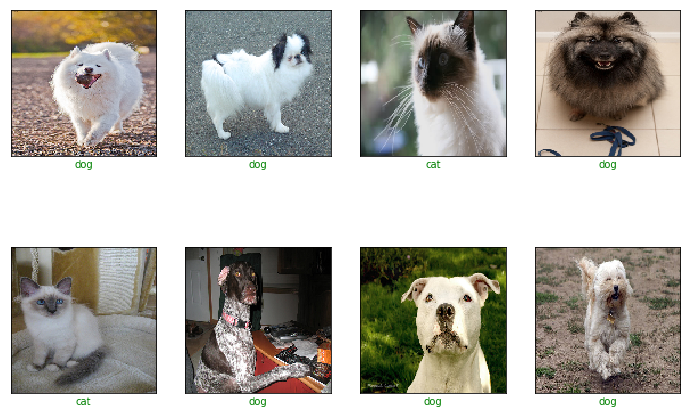

In [61]:
display_examples(x_test,y_test,y_pred,images_test,index_to_class).show()